<a href="https://colab.research.google.com/github/nomnomnonono/Image-Completion/blob/main/GLCIC/GLCIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan  6 09:04:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## ライブラリの読み込み

In [8]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/experiment/final")

In [9]:
import torch
from torch.nn import BCELoss, DataParallel
from torch.nn.functional import mse_loss
from torch.optim import Adadelta, Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

from PIL import Image
import joblib
import json
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from datasets import ImageDataset
from models import CompletionNetwork, ContextDiscriminator
from tools import crop, define_hole_area, generate_mask, generate_multiple_mask, generate_circle_mask, get_completion_image, sample_random_batch

## 初期設定

In [33]:
data_dir = "img_align_celeba"
result_dir = "/content/drive/MyDrive/Colab Notebooks/experiment/final/result"
recursive_search = False
data_parallel = False
device = torch.device('cuda')
init_model_cn = os.path.join(result_dir, 'phase_4', 'cn_step40000.pth')
init_model_cd = os.path.join(result_dir, 'phase_4', 'cd_step40000.pth')
cn_input_size = 120
ld_input_size = 72
hole_min_w = 36
hole_max_w = 72
hole_min_h = 36
hole_max_h = 72
n_holes = 4
radius_min = 30
radius_max = 40
steps1 = 90000
steps2 = 10000
steps3 = 400000
steps4 = 100000
snaperiod1 = 10000
snaperiod2 = 1000
snaperiod3 = 10000
snaperiod4 = 10000
bsize = 16
bdivs = 1
alpha = 4e-4
num_test_completions = 16

## 画像の読み込み

In [11]:
!mkdir train test

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists


In [12]:
!cp "/content/drive/MyDrive/Colab Notebooks/experiment/final/img_align_celeba.zip" "."
!unzip -q img_align_celeba.zip
!mv img_align_celeba/2* test/

In [13]:
# Number of Images
!ls "img_align_celeba" -1 | wc -l
!ls "test" -1 | wc -l

199999
2600


In [14]:
if not os.path.exists(result_dir):
        os.makedirs(result_dir)
for phase in ['phase_1', 'phase_2', 'phase_3']:
    if not os.path.exists(os.path.join(result_dir, phase)):
        os.makedirs(os.path.join(result_dir, phase))

## データセット

In [15]:
transform = transforms.Compose([
        transforms.Resize(cn_input_size),
        transforms.RandomCrop((cn_input_size, cn_input_size)),
        transforms.ToTensor(),
])

train = ImageDataset('img_align_celeba', transform, recursive_search=recursive_search)
train_loader = DataLoader(train, batch_size=bsize//bdivs, shuffle=True)
test = ImageDataset('test', transform, recursive_search=recursive_search)

## mpvの計算・読み込み

In [ ]:
mpv = np.zeros(shape=(3,))
pbar = tqdm(total=len(train.imgpaths),
            desc='computing mean pixel value')
for img_path in train.imgpaths:
  img = Image.open(img_path)
  x = np.array(img).astype('float32') / 255.
  mpv += x.mean(axis=(0, 1))
  pbar.update()
mpv /= len(train.imgpaths)
pbar.close

computing mean pixel value: 100%|█████████▉| 199950/199999 [06:26<00:00, 525.50it/s]

<bound method tqdm.close of <tqdm.std.tqdm object at 0x7fda5bfef3d0>>

In [16]:
mpv_json = open(os.path.join(result_dir, 'config.json'), 'r')
mpv_data = json.load(mpv_json)
mpv = mpv_data['mpv']
mpv = np.array(mpv)

In [17]:
mpv = torch.tensor(mpv.reshape(1, 3, 1, 1), dtype=torch.float32).to(device)
alpha = torch.tensor(alpha, dtype=torch.float32).to(device)

## Training

### Phase 1
pre-train Generator

In [ ]:
model_cn = CompletionNetwork()
if init_model_cn is not None:
  model_cn.load_state_dict(torch.load(init_model_cn, map_location='cpu'))
if data_parallel:
  model_cn = DataParallel(model_cn)
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss = []

In [ ]:
cnt_bdivs = 0
pbar = tqdm(total=steps1-10000)

while pbar.n < steps1-10000:
  for x in train_loader:
    # forward
    x = x.to(device)
    mask = generate_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=((hole_min_w, hole_max_w),
                   (hole_min_h, hole_max_h)),
        hole_area=define_hole_area(
            (ld_input_size, ld_input_size),
            (x.shape[3], x.shape[2])
        )[0]
    ).to(device)
    x_mask = x - x * mask + mpv * mask
    input = torch.cat((x_mask, mask), dim=1)
    output = model_cn(input)
    loss = mse_loss(x*mask, output*mask)
    G_loss.append(loss)

    # backward
    loss.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description('phase 1 | train loss: %.5f' % loss.cpu())
      pbar.update()

      # test
      if pbar.n % snaperiod1 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=((hole_min_w, hole_max_w),
                         (hole_min_h, hole_max_h)),
              hole_area=define_hole_area(
              (ld_input_size, ld_input_size),
              (x.shape[3], x.shape[2])
              )[0]
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          # 結果とモデルの保存
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          img_path = os.path.join(
              result_dir, 'phase_1', 'step%d.jpg' % (pbar.n+10000)
          )
          save_image(imgs, img_path, nrow=len(x))
          model_cn_path = os.path.join(
              result_dir, 'phase_1', 'step%d.pth' % (pbar.n+10000)
          )
          torch.save(
              model_cn.state_dict(),
              model_cn_path
          )
        model_cn.train()
      if pbar.n >= steps1-10000:
        break
    break
pbar.close()

In [ ]:
before = joblib.load(os.path.join(result_dir, 'phase_1', 'G_loss10000.txt'))

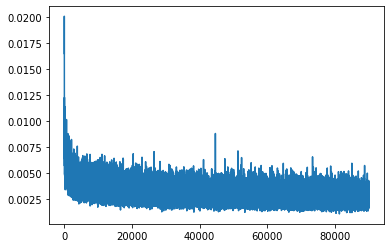

In [ ]:
total_loss = list(itertools.chain(before, G_loss))

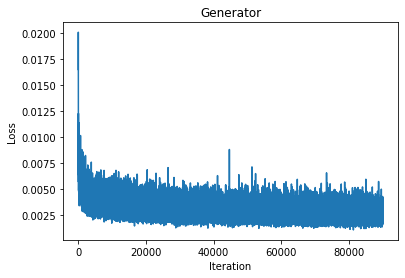

In [ ]:
fig = plt.figure()
plt.plot(total_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator')
fig.savefig(os.path.join(result_dir, 'phase_1', 'G_loss90000.png'))

In [ ]:
joblib.dump(total_loss, os.path.join(result_dir, 'phase_1', 'G_loss90000.txt'))

['/content/drive/MyDrive/Colab Notebooks/experiment/final/result/phase_1/G_loss90000.txt']

### Phase2
pre-train Discriminator

In [ ]:
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
if init_model_cd is not None:
  model_cd.load_state_dict(torch.load(init_model_cd, map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss = []

In [ ]:
cnt_bdivs = 0
pbar = tqdm(total=steps2-1000)
while pbar.n < steps2-1000:
  for x in train_loader:
    x = x.to(device)
    # fake forward
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    mask = generate_mask(
        shape=(
            x.shape[0], 1, x.shape[2], x.shape[3]
        ),
        hole_size=(
            (hole_min_w, hole_max_w), (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0]
    ).to(device)
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((
        input_ld_fake.to(device),
        input_gd_fake.to(device)))
    loss_fake = loss_cd(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_real = loss_cd(output_real, real)

    loss = (loss_fake + loss_real) / 2
    D_loss.append(loss)

    # backward
    loss.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      opt_cd.step()
      opt_cd.zero_grad()
      pbar.set_description('phase 2 | train loss: %.5f' % loss.cpu())
      pbar.update()

      # test
      if pbar.n % snaperiod2 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(test, batch_size=num_test_completions).to(device)
          mask = generate_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=((hole_min_w, hole_max_w),
                         (hole_min_h, hole_max_h)),
              hole_area=define_hole_area(
              (ld_input_size, ld_input_size),
              (x.shape[3], x.shape[2])
              )[0]
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          img_path = os.path.join(
              result_dir, 'phase_2', 'step%d.jpg' % (pbar.n+1000)
          )
          save_image(imgs, img_path, nrow=len(x))
          model_path = os.path.join(
              result_dir, 'phase_2', 'step%d.pth' % (pbar.n+1000)
          )
          torch.save(model_cd.state_dict(), model_path)
        model_cn.train()
      if pbar.n >= steps2-1000:
        break
pbar.close()

phase 2 | train loss: 0.00004:   0%|          | 31/9000 [00:10<50:17,  2.97it/s]
phase 2 | train loss: 0.00000: 100%|██████████| 9000/9000 [23:54<00:00,  6.27it/s]


In [ ]:
before = joblib.load(os.path.join(result_dir, 'phase_2', 'D_loss1000.txt'))

In [ ]:
total_loss = list(itertools.chain(before, D_loss))

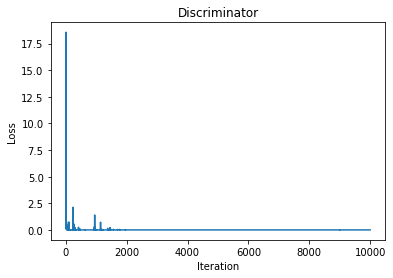

In [ ]:
fig = plt.figure()
plt.plot(total_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator')
fig.savefig(os.path.join(result_dir, 'phase_2', 'D_loss10000.png'))

In [ ]:
joblib.dump(total_loss, os.path.join(result_dir, 'phase_2', 'D_loss10000.txt'))

['/content/drive/MyDrive/Colab Notebooks/experiment/final/result/phase_2/D_loss10000.txt']

### Phase3
train Generator & Discriminator

In [ ]:
G_loss2 = []
D_loss2 = []

In [ ]:
cnt_bdivs = 0
bceloss = BCELoss()
pbar =tqdm(total=steps3//10-20000)

while pbar.n < steps3//10-20000:
  for x in train_loader:
    ## forward model_cd
    x = x.to(device)
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2]))
    mask = generate_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=(
            (hole_min_w, hole_max_w),
            (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0]
    ).to(device)
    # fake forward
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cd_fake = bceloss(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_cd_real = bceloss(output_real, real)
    ## backward model_cd
    loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.
    D_loss2.append(loss_cd)
    loss_cd.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      # optimize
      opt_cd.step()
      opt_cd.zero_grad()
    ## forward model_cn
    loss_cn_1 = mse_loss(x*mask, output_cn*mask)
    input_gd_fake = output_cn
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cn_2 = bceloss(output_fake, real)
    ## backward model_cn
    loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.
    G_loss2.append(loss_cn)
    loss_cn.backward()
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      # optimize
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description(
          'phase3 | train loss (cd): %.5f (cn): %5.f' % (
              loss_cd.cpu(),
              loss_cn.cpu()
          )
      )
      pbar.update()
      ## test
      if pbar.n % snaperiod3 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=(
                  (hole_min_w, hole_max_w),
                  (hole_min_h, hole_max_h)
              ),
              hole_area=define_hole_area(
                  (ld_input_size, ld_input_size),
                  (x.shape[3], x.shape[2])
              )[0]
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          imgpath = os.path.join(
              result_dir, 'phase_3', 'step%d.png' % (pbar.n+480000)
          )
          model_cn_path = os.path.join(
              result_dir, 'phase_3', 'cn_step%d.pth' % (pbar.n+480000)
          )
          model_cd_path = os.path.join(
              result_dir, 'phase_3', 'cd_step%d.pth' % (pbar.n+480000)
          )
          save_image(imgs, imgpath, nrow=len(x))
          torch.save(model_cn.state_dict(), model_cn_path)
          torch.save(model_cd.state_dict(), model_cd_path)
        model_cn.train()
      if pbar.n >= steps3//10-20000:
        break;
pbar.close()

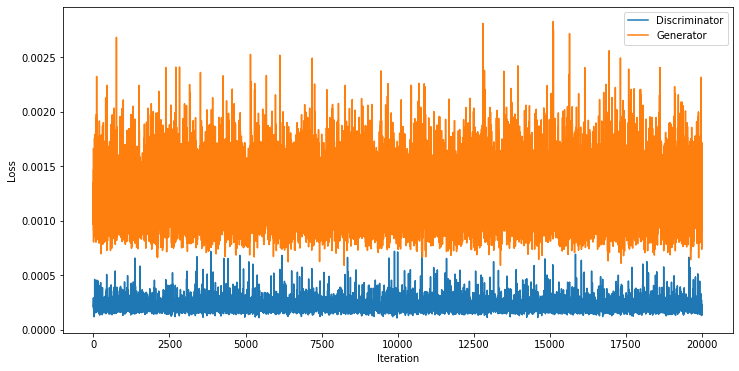

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(D_loss2, label='Discriminator')
plt.plot(G_loss2, label='Generator')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
#fig.savefig(os.path.join(result_dir, 'phase_3', 'DG_loss40000.png'))

In [ ]:
joblib.dump(D_loss2, os.path.join(result_dir, 'phase_3', 'D_loss480000-500000.txt'))
joblib.dump(G_loss2, os.path.join(result_dir, 'phase_3', 'G_loss480000-500000.txt'))

['/content/drive/MyDrive/Colab Notebooks/experiment/final/result/phase_3/G_loss480000-500000.txt']

## Phase4
train Generator & Discriminator with multiple holes

In [19]:
if not os.path.exists(os.path.join(result_dir, 'phase_4')):
  os.makedirs(os.path.join(result_dir, 'phase_4'))

In [20]:
model_cn = CompletionNetwork()
model_cn.load_state_dict(torch.load(os.path.join(result_dir, 'phase_4', 'cn_step40000.pth'), map_location='cpu'))
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss4 = []
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd.load_state_dict(torch.load(os.path.join(result_dir, 'phase_4', 'cd_step40000.pth'), map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss4 = []

In [21]:
cnt_bdivs = 0
bceloss = BCELoss()
pbar =tqdm(total=steps4)

while pbar.n < steps4:
  for x in train_loader:
    ## forward model_cd
    x = x.to(device)
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2]))
    mask = generate_multiple_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=(
            (hole_min_w, hole_max_w),
            (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0],
        n_holes=n_holes
    ).to(device)
    # fake forward
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cd_fake = bceloss(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_cd_real = bceloss(output_real, real)
    ## backward model_cd
    loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.
    D_loss4.append(loss_cd)
    loss_cd.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      # optimize
      opt_cd.step()
      opt_cd.zero_grad()
    ## forward model_cn
    loss_cn_1 = mse_loss(x*mask, output_cn*mask)
    input_gd_fake = output_cn
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cn_2 = bceloss(output_fake, real)
    ## backward model_cn
    loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.
    G_loss4.append(loss_cn)
    loss_cn.backward()
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      # optimize
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description(
          'phase4 | train loss (cd): %.5f (cn): %5.f' % (
              loss_cd.cpu(),
              loss_cn.cpu()
          )
      )
      pbar.update()
      ## test
      if pbar.n % snaperiod4 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_multiple_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=(
                  (hole_min_w, hole_max_w),
                  (hole_min_h, hole_max_h)
              ),
              hole_area=define_hole_area(
                  (ld_input_size, ld_input_size),
                  (x.shape[3], x.shape[2])
              )[0],
              n_holes=n_holes
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          imgpath = os.path.join(
              result_dir, 'phase_4', 'step%d.png' % (pbar.n)
          )
          model_cn_path = os.path.join(
              result_dir, 'phase_4', 'cn_step%d.pth' % (pbar.n)
          )
          model_cd_path = os.path.join(
              result_dir, 'phase_4', 'cd_step%d.pth' % (pbar.n)
          )
          save_image(imgs, imgpath, nrow=len(x))
          torch.save(model_cn.state_dict(), model_cn_path)
          torch.save(model_cd.state_dict(), model_cd_path)
        model_cn.train()
      if pbar.n >= steps4:
        break;
pbar.close()

phase4 | train loss (cd): 0.00024 (cn):     0: 100%|██████████| 60000/60000 [4:37:14<00:00,  3.61it/s]


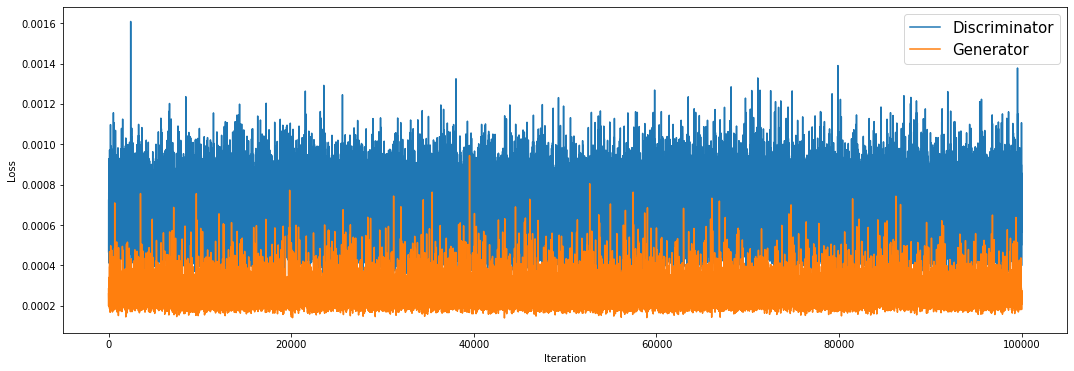

In [38]:
fig = plt.figure(figsize=(18,6))
plt.plot(G_loss4, label='Discriminator')
plt.plot(D_loss4, label='Generator')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(fontsize=15)
fig.savefig(os.path.join(result_dir, 'phase_4', 'DG_loss100000.png'))

In [39]:
joblib.dump(D_loss4, os.path.join(result_dir, 'phase_4', 'D_loss100000.txt'))
joblib.dump(G_loss4, os.path.join(result_dir, 'phase_4', 'G_loss100000.txt'))

['/content/drive/MyDrive/Colab Notebooks/experiment/final/result/phase_4/G_loss100000.txt']